# NOT MY ORIGINAL WORK

This is taken from here:

https://github.com/bjlkeng/sandbox/blob/master/notebooks/vae-semi_supervised_learning/vae-m2-fit-mnist.ipynb

In [32]:
%matplotlib inline
import numpy as np
import time
import h5py
import keras
import pandas as pd
import math
import joblib
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from IPython.display import display

from tensorflow.keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, Activation, 
                          Dropout, Conv2D, Conv2DTranspose, MaxPooling2D)
from tensorflow.keras.layers import concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist

In [33]:
img_rows, img_cols, img_chns = 28, 28, 1

if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)

batch_size = 200
latent_dim = 128
intermediate_dim = 512
epsilon_std = 1.0
epochs = 10
activation = 'relu'
dropout = 0.5
learning_rate = 0.001
decay = 0.0
num_classes = 10

In [34]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1) / 255.
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1) / 255.

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)


In [35]:
def create_enc_conv_layers(stage, **kwargs):
    conv_name = '_'.join(['enc_conv', str(stage)])
    bn_name = '_'.join(['enc_bn', str(stage)])
    layers = [
        Conv2D(name=conv_name, **kwargs),
        BatchNormalization(name=bn_name),
        Activation(activation),
    ]
    return layers

def create_dense_layers(stage, width):
    dense_name = '_'.join(['enc_conv', str(stage)])
    bn_name = '_'.join(['enc_bn', str(stage)])
    layers = [
        Dense(width, name=dense_name),
        BatchNormalization(name=bn_name),
        Activation(activation),
        Dropout(dropout),
    ]
    return layers

def inst_layers(layers, in_layer):
    x = in_layer
    for layer in layers:
        if isinstance(layer, list):
            x = inst_layers(layer, x)
        else:
            x = layer(x)
        
    return x

In [36]:
enc_filters=64
enc_layers = [
    create_enc_conv_layers(stage=1, filters=enc_filters, kernel_size=3, strides=1, padding='same'),
    #create_enc_conv_layers(stage=2, filters=enc_filters, kernel_size=3, strides=1, padding='same'),
    #create_enc_conv_layers(stage=3, filters=enc_filters, kernel_size=3, strides=2, padding='same'),
    Flatten(),
    create_dense_layers(stage=4, width=intermediate_dim),
]

In [37]:
# Labeled encoder
x_in = Input(batch_shape=(batch_size,) + original_img_size)
y_in = Input(batch_shape=(batch_size, num_classes))
_enc_dense = inst_layers(enc_layers, x_in)

_z_mean_1 = Dense(latent_dim)(_enc_dense)
_z_log_var_1 = Dense(latent_dim)(_enc_dense)

z_mean = _z_mean_1
z_log_var = _z_log_var_1

In [38]:
def sampling(args, batch_size=batch_size, latent_dim=latent_dim, epsilon_std=epsilon_std):
    z_mean, z_log_var = args
    
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., stddev=epsilon_std)
    
    return z_mean + K.exp(z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Classifier Network

In [39]:
classifier_layers = [
    Conv2D(32, (3, 3), padding='same', name='classifier_start'),
    Activation('relu'),
    #Conv2D(32, (3, 3)),
    #Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), padding='same'),
    Activation('relu'),
    #Conv2D(64, (3, 3)),
    #Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(512),
    Activation('relu'),
    Dropout(0.5),
    Dense(num_classes),
    Activation('softmax', name='classifier_out'),
]

In [40]:
_cls_output = inst_layers(classifier_layers, x_in)
_y_output = _cls_output

# Decoder Network

In [41]:
def create_dec_trans_conv_layers(stage, **kwargs):
    conv_name = '_'.join(['dec_trans_conv', str(stage)])
    bn_name = '_'.join(['dec_bn', str(stage)])
    layers = [
        Conv2DTranspose(name=conv_name, **kwargs),
        BatchNormalization(name=bn_name),
        Activation(activation),
    ]
    return layers

In [42]:
dec_filters = 64
decoder_layers = [
    create_dense_layers(stage=10, width=14 * 14 * 64),
    Reshape((14, 14, 64)),
    create_dec_trans_conv_layers(11, filters=dec_filters, kernel_size=3, strides=1, padding='same'),
    #create_dec_trans_conv_layers(12, filters=dec_filters, kernel_size=3, strides=1, padding='same'),
    #create_dec_trans_conv_layers(13, filters=dec_filters, kernel_size=3, strides=2, padding='same'),
    Conv2DTranspose(name='x_decoded', filters=1, kernel_size=1, strides=1, activation='sigmoid'),
]

In [43]:
# Labeled decoder
_merged = concatenate([y_in, z])
_dec_out = inst_layers(decoder_layers, _merged)
_x_output = _dec_out

# Unlabeled decoder
u_merged = concatenate([_y_output, z])
u_dec_out = inst_layers(decoder_layers, u_merged)
u_x_output = u_dec_out

# Loss Function

In [44]:
def kl_loss(x, x_decoded_mean, z_mean=z_mean, z_log_var=z_log_var):
    kl_loss = - 0.5 * K.sum(1. + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
   
    return K.mean(kl_loss)

def logxy_loss(x, x_decoded_mean):
    x = K.flatten(x)
    x_decoded_mean = K.flatten(x_decoded_mean)
    xent_loss = img_rows * img_cols * img_chns * metrics.binary_crossentropy(x, x_decoded_mean)
   
    # p(y) for observed data is equally distributed
    logy = np.log(1. / num_classes)
    
    return xent_loss - logy

def labeled_vae_loss(x, x_decoded_mean):
    return logxy_loss(x, x_decoded_mean) + kl_loss(x, x_decoded_mean)

def cls_loss(y, y_pred, N=1000):
    alpha = 0.1 * N
    return alpha * metrics.categorical_crossentropy(y, y_pred)

def unlabeled_vae_loss(x, x_decoded_mean):
    entropy = metrics.categorical_crossentropy(_y_output, _y_output)
    # This is probably not correct, see discussion here: https://github.com/bjlkeng/sandbox/issues/3
    labeled_loss = logxy_loss(x, x_decoded_mean) + kl_loss(x, x_decoded_mean)
    
    return K.mean(K.sum(_y_output * labeled_loss, axis=-1)) + entropy

# Compile Model

In [45]:
label_vae = Model(inputs=[x_in, y_in], outputs=[_x_output, _y_output])
optimizer = Adam(lr=learning_rate, decay=decay)
label_vae.compile(optimizer=optimizer, loss=[labeled_vae_loss, cls_loss])
label_vae.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(200, 28, 28, 1)]   0                                            
__________________________________________________________________________________________________
enc_conv_1 (Conv2D)             (200, 28, 28, 64)    640         input_3[0][0]                    
__________________________________________________________________________________________________
enc_bn_1 (BatchNormalization)   (200, 28, 28, 64)    256         enc_conv_1[0][0]                 
__________________________________________________________________________________________________
activation_21 (Activation)      (200, 28, 28, 64)    0           enc_bn_1[0][0]                   
____________________________________________________________________________________________

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [46]:
unlabeled_vae = Model(inputs=x_in, outputs=u_x_output)
optimizer = Adam(lr=learning_rate, decay=decay)
unlabeled_vae.compile(optimizer=optimizer, loss=unlabeled_vae_loss)
unlabeled_vae.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(200, 28, 28, 1)]   0                                            
__________________________________________________________________________________________________
classifier_start (Conv2D)       (200, 28, 28, 32)    320         input_3[0][0]                    
__________________________________________________________________________________________________
activation_23 (Activation)      (200, 28, 28, 32)    0           classifier_start[0][0]           
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (200, 14, 14, 32)    0           activation_23[0][0]              
____________________________________________________________________________________________

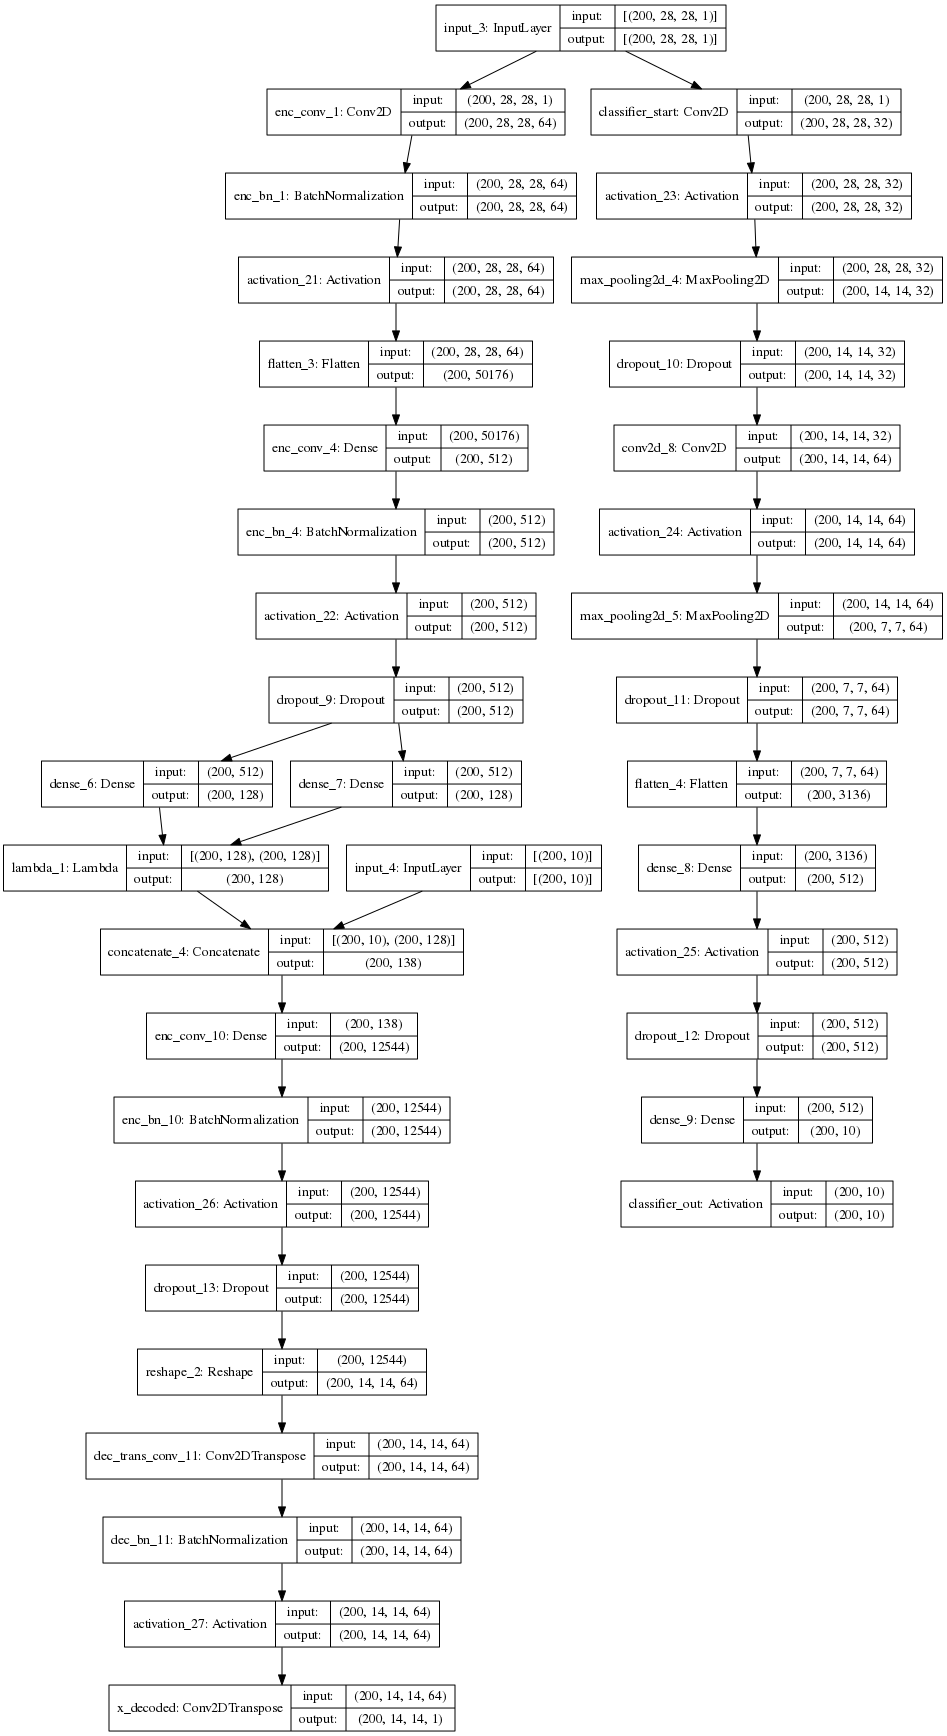

In [47]:
display(plot_model(label_vae, show_layer_names=True, show_shapes=True, dpi=72))

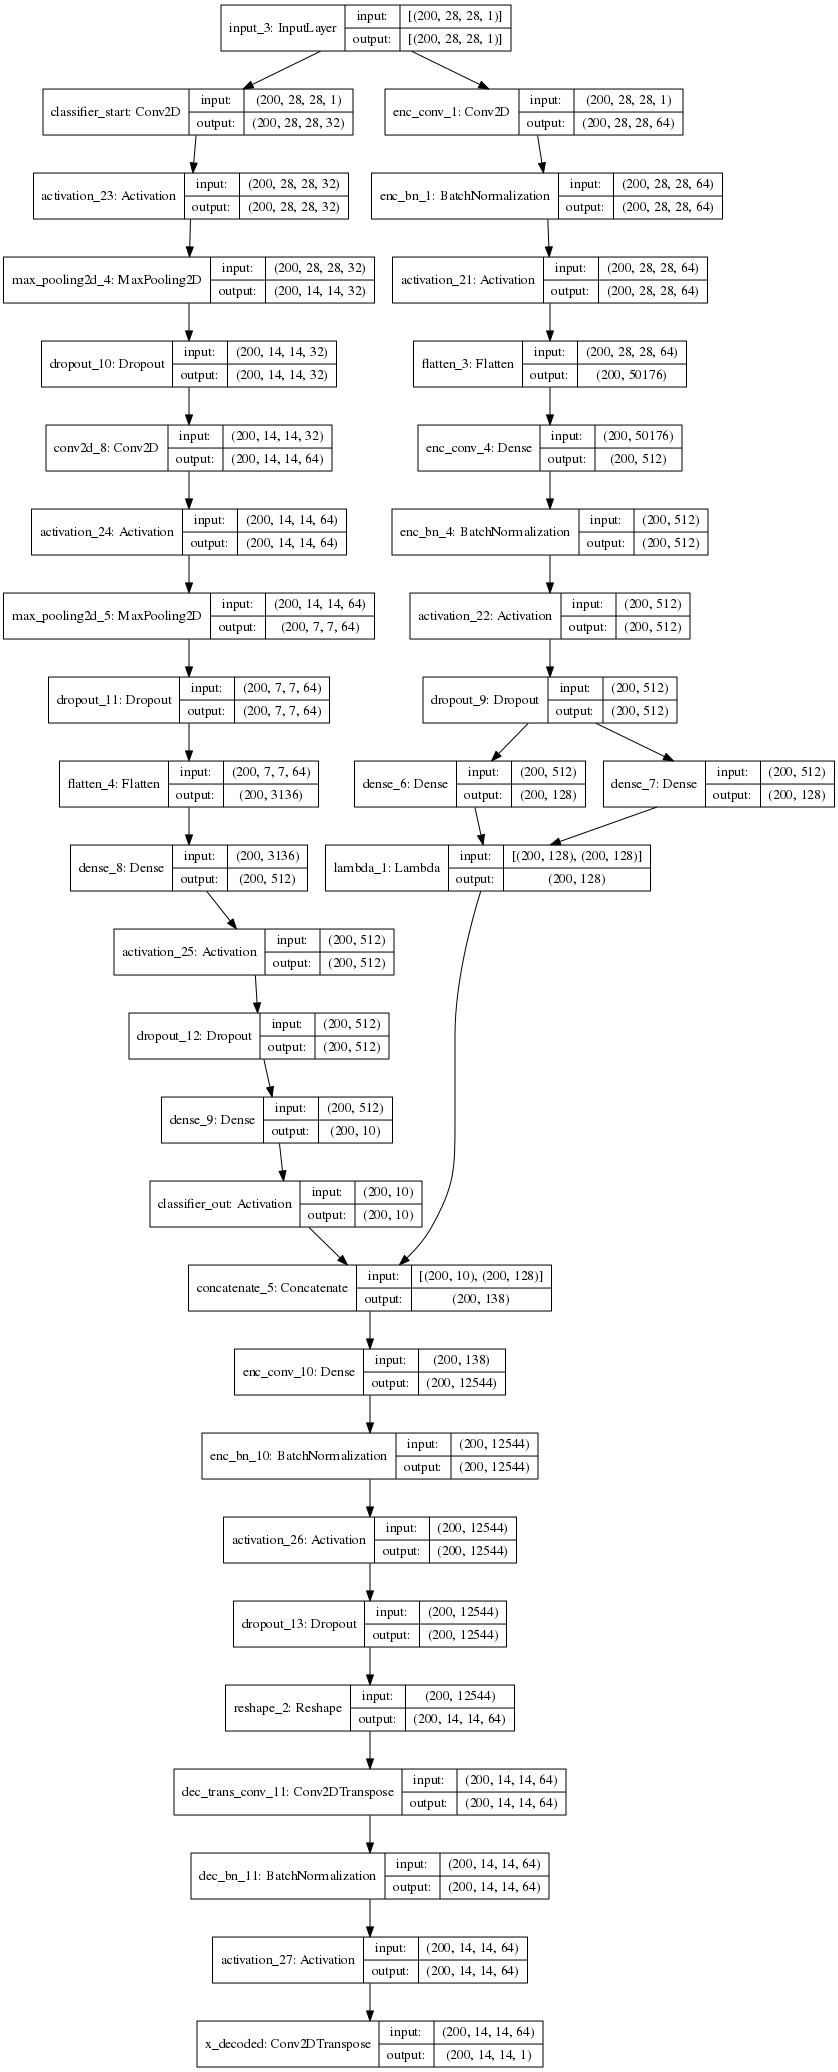

In [48]:
display(plot_model(unlabeled_vae, show_layer_names=True, show_shapes=True, dpi=72))